# Importing packages

In [1]:
from matplotlib import pyplot as plt
from sklearn.datasets import load_svmlight_file
import numpy as np
import pickle

In [2]:
import pandas as pd

# Functions

In [3]:
def loss(w, X, y, lambda_):
    z = - X.toarray() * y[:, None]
    exp = np.exp(z @ w)
    log = np.log(1 + exp)
    loss_1 = log.mean()
    reg = 1. - 1. / (w ** 2 + 1.)
    reg = reg.sum()
    return loss_1 + lambda_ * reg

In [4]:
def grad(w, X, y, lambda_):
    z = - X.toarray() * y[:, None]
    coef = 1. - 1. / (1 + np.exp(z @ w))
    grad_loss_1 = (z * coef[:, None]).mean(axis=0)
    grad_loss_2 = 2 * w * (1. / (1 + w ** 2) ** 2)
    return grad_loss_1 + lambda_ * grad_loss_2

In [5]:
def grad_compute(w, data, lambda_):
    return np.array([grad(w, feats, labels, lambda_)
                    for (feats, labels) in data], dtype=np.longdouble)

In [6]:
def smoothness(features, lambda_):
    xtx = features.T.dot(features)
    xtx = xtx.toarray()
    n = features.shape[0]
    return np.max(np.linalg.eigvalsh(xtx)) / (4 * n) + 2 * lambda_

In [7]:
def top_k(vec, k):
    assert len(vec) >= k
    inds = np.argsort(vec)[-k:]
    inds = list(inds)
    mask = np.zeros_like(vec)
    mask[inds] = 1
    return np.multiply(vec, mask)

In [8]:
def beta_top_k(k, d):
    alpha = float(k) / float(d)
    return (1 - alpha) / (1 - np.sqrt(1 - alpha))

In [9]:
def print_and_return(hist_list):
    min_ind = 0
    curr_ind = 0
    min_val = hist_list[0][0][-1]
    for hist in hist_list:
        if hist[0][-1] < min_val:
            min_ind = curr_ind
            min_val = hist[0][-1]
        curr_ind += 1
        print(hist[0][-1], hist[1][-1])
    return min_ind

# Algorithms

In [ ]:
def LAG_step(x_k, g_k, comm, data, lambda_, grad_k_prev, zeta, stepsize):
    x_k -= stepsize * g_k.mean(axis=0)
    grad_k = np.array(grad_compute(x_k, data, lambda_), dtype=np.float64)
    trigger_rhs = zeta * np.linalg.norm(grad_k - grad_k_prev, ord=2, axis=1)
    trigger_lhs = np.linalg.norm(g_k - grad_k, ord=2, axis=1)
    trigger = np.expand_dims(np.array(trigger_lhs > trigger_rhs), 1)
    g_k = np.multiply(grad_k, trigger) + np.multiply(g_k, 1 - trigger)
    comm += len(x_k) * trigger.sum()
    return x_k, g_k, grad_k, comm

In [ ]:
def LAG(x_0, data, lambda_, zeta, max_comm):
    g_k = np.array(grad_compute(x_0, data, lambda_), dtype=np.longdouble)
    grad_k_prev = np.array(np.copy(g_k))
    x_k = np.array(np.copy(x_0))
    history = [np.linalg.norm(g_k.mean(axis=0))]
    comm = len(data) * len(x_0)
    history_comm = [0]
    stepsize = 1. / (L + L_tilde * np.sqrt(zeta))
    while(history_comm[-1] < max_comm):
        x_k, g_k, grad_k_prev, comm = LAG_step(
            x_k, g_k, comm, data, lambda_, grad_k_prev, zeta, stepsize
        )
        history.append(np.linalg.norm(grad_k_prev.mean(axis=0)))
        history_comm.append(comm)
        print('Currently communicated {} float numbers'.format(comm), end='\r')
    return history, history_comm

In [ ]:
def GD(x_0, data, lambda_, num_clients, max_iter):
    g_k = None
    x_k = np.array(np.copy(x_0), dtype=np.longdouble)
    history = []
    history_comm = []
    stepsize = 1. / L
    comm = 0
    for i in range(max_iter):
        g_k = np.array(grad_compute(x_k, data, lambda_), dtype=np.longdouble)
        print('Iteration {} / {}'.format(i + 1, max_iter), end='\r')
        grad_ = g_k.mean(axis=0)
        history.append(np.linalg.norm(grad_))
        history_comm.append(comm)
        x_k -= stepsize * grad_
        comm += num_clients * len(x_0)
    return history, history_comm

In [76]:
def CLAG_step(x_k, g_k, comm, data, lambda_,
              trigger_beta, grad_k_prev, k, stepsize):
    x_k -= stepsize * g_k.mean(axis=0, dtype=np.longdouble)
    grad_k = np.array(grad_compute(x_k, data, lambda_), dtype=np.longdouble)
    trigger_rhs = trigger_beta * np.linalg.norm(
        grad_k - grad_k_prev, ord=2, axis=1)
    print(trigger_rhs.shape)
    trigger_lhs = np.linalg.norm(g_k - grad_k, ord=2, axis=1)
    trigger = np.expand_dims(np.array(trigger_lhs > trigger_rhs), 1)
    print(trigger)
    compressed = np.vstack([top_k(grad_k[i] - g_k[i], k)
                            for i in range(len(g_k))])
    print(np.multiply(compressed, trigger))
    g_k += np.multiply(compressed, trigger)
    comm += trigger.sum() * k
    return x_k, g_k, grad_k, comm

In [11]:
def CLAG(x_0, data, lambda_, k, trigger_beta, max_comm):
    assert trigger_beta > 0
    alpha = float(k) / len(x_0)
    beta = beta_top_k(k, len(x_0))
    theta = 1 - np.sqrt(1 - alpha)
    g_k = np.array(grad_compute(x_0, data, lambda_), dtype=np.longdouble)
    grad_k_prev = np.array(np.copy(g_k))
    x_k = np.array(np.copy(x_0))
    history = [np.linalg.norm(g_k.mean(axis=0))]
    history_comm = [0]
    comm = len(x_0) * len(data)
    stepsize = 1. / (L + L_tilde * np.sqrt(max(beta, trigger_beta)/theta))
    while(history_comm[-1] < max_comm):
        print('Currently communicated {} float numbers'.format(comm), end='\r')
        history_comm.append(int(comm))
        x_k, g_k, grad_k_prev, comm = CLAG_step(
            x_k, g_k, comm, data, lambda_, trigger_beta,
            grad_k_prev, k, stepsize
        )
        history.append(np.linalg.norm(grad_k_prev.mean(axis=0)))
    return history, history_comm

In [77]:
def CLAG_it(x_0, data, lambda_, k, trigger_beta, tol):
    assert trigger_beta >= 0
    alpha = float(k) / len(x_0)
    beta = beta_top_k(k, len(x_0))
    theta = 1 - np.sqrt(1 - alpha)
    g_k = np.array(grad_compute(x_0, data, lambda_), dtype=np.longdouble)
    grad_k_prev = np.copy(g_k)
    x_k = np.array(np.copy(x_0))
    comm = len(x_0) * len(data)
    stepsize = 1. / (L + L_tilde * np.sqrt(max(beta, trigger_beta)/theta))
    print('Log: beta {}, theta{}, zeta {}, stepsize {}'.format(beta, theta, trigger_beta, stepsize))
    while np.linalg.norm(grad_k_prev.mean(axis=0)) > tol:
        x_k, g_k, grad_k_prev, comm = CLAG_step(
            x_k, g_k, comm, data, lambda_, trigger_beta,
            grad_k_prev, k, stepsize
        )
        print('Tolerance = ', np.linalg.norm(grad_k_prev.mean(axis=0)),
              end='\r')
    print('')
    return comm

In [78]:
def heatmap_CLAG(x_0, data, lambda_, ks, trigger_betas, tol, file):
    heatmap = np.zeros(shape=(len(ks), len(trigger_betas)))
    for k_id, k in enumerate(ks):
        print('k = ', k)
        for beta_id, trigger_beta in enumerate(trigger_betas):
            print('trigger_beta = ', trigger_beta)
            heatmap[k_id, beta_id] = CLAG_it(x_0,
                                             data,
                                             lambda_,
                                             k,
                                             trigger_beta,
                                             tol)
            np.save(file, heatmap)
    return heatmap

In [ ]:
def EF21(x_0, data, lambda_, k, max_iter):
    alpha = float(k) / len(x_0)
    beta = (1 - alpha) / (1 - np.sqrt(1 - alpha))
    theta = 1 - np.sqrt(1 - alpha)
    g_k = np.array(grad_compute(x_0, data, lambda_), dtype=np.longdouble)
    x_k = np.array(np.copy(x_0))
    history = [np.linalg.norm(g_k.mean(axis=0))]
    history_comm = [0]
    comm = len(x_0) * len(data)
    stepsize = 1. / (L + L_tilde * np.sqrt(beta/theta))
    for i in range(max_iter):
        print('Currently communicated {} float numbers'.format(comm), end='\r')
        x_k -= stepsize * g_k.mean(axis=0)
        history_comm.append(int(comm))
        grad_k = np.array(grad_compute(x_k, data, lambda_), dtype=np.float64)
        history.append(np.linalg.norm(grad_k.mean(axis=0)))
        compressed = np.vstack([top_k(grad_k[i] - g_k[i], k)
                                 for i in range(len(g_k))])
        g_k += compressed
        comm += len(data) * k
        print(comm, end='\r')
    return history, history_comm

# Phishing dataset

## Setup

In [79]:
num_clients = 20

In [49]:
lambda_ = 0.1

In [50]:
raw_data = load_svmlight_file('../data/phishing')

In [51]:
X, y = raw_data

In [52]:
res = X.shape[0] % num_clients

In [53]:
res

15

In [54]:
y = 2 * y - 1

In [55]:
X = X[:-res]
y = y[:-res]

In [56]:
n = X.shape[0]

In [57]:
d = X.shape[1]

In [58]:
y

array([-1., -1., -1., ..., -1., -1., -1.])

In [59]:
inds = np.array_split(np.arange(n), num_clients)

In [60]:
data = []
for i in range(num_clients):
    data.append((X[inds[i]][:], y[inds[i]]))

In [61]:
L = smoothness(X, lambda_)

In [62]:
L

0.3625653679762366

In [63]:
L_i = [smoothness(data[i][0], lambda_) for i in range(num_clients)]

In [64]:
L_tilde = np.sqrt((np.array(L_i) ** 2).mean())

In [65]:
L_tilde

0.3660995652574401

## Experiments

In [67]:
max_comm = 20000

### 1. LAG tuning

In [ ]:
zetas = np.geomspace(1e-2, 1e1, 4)

In [ ]:
zetas

In [ ]:
def LAG_grid(x_0, data, lambda_, zetas, max_comm):
    LAG_histories = []
    for zeta in zetas:
        print('zeta = {}'.format(zeta), end='\r')
        hist = LAG(x_0, data, lambda_, zeta, max_comm)
        LAG_histories.append(hist)
    return LAG_histories

In [ ]:
x_0 = np.zeros(d)

In [ ]:
LAG_histories = LAG_grid(x_0, data, lambda_, zetas, max_comm)

In [ ]:
with open('../results/lag_phishing.pickle', 'wb') as file:
    pickle.dump(LAG_histories, file)

In [ ]:
with open('../results/lag_phishing.pickle', 'rb') as file:
    LAG_histories = pickle.load(file)

In [ ]:
min_ind = print_and_return(LAG_histories)

In [ ]:
print(min_ind)

In [ ]:
h_LAG, h_LAG_comm = LAG_histories[min_ind]

In [ ]:
new_h_LAG, new_h_LAG_comm = LAG(x_0, data, lambda_, 1., max_comm)

In [ ]:
# preliminary plot
plt.plot(h_LAG_comm, h_LAG)
plt.plot(new_h_LAG_comm, new_h_LAG)
plt.yscale('log')

### 2. EF21 tuning

In [ ]:
ks = np.linspace(1, d, 10, endpoint=False, dtype=int)

In [ ]:
ks

In [ ]:
def EF21_grid(x_0, data, d, lambda_, ks, max_comm):
    EF21_histories = []
    for k in ks:
        print('k=', k)
        max_iter = 2 + int((max_comm - d * len(data)) / (k * num_clients))
        hist = EF21(x_0, data, lambda_, k, max_iter)
        EF21_histories.append(hist)
    return EF21_histories

In [ ]:
EF21_histories = EF21_grid(x_0, data, d, lambda_, ks, max_comm)

In [ ]:
with open('../results/ef21_phishing.pickle', 'wb') as file:
    pickle.dump(EF21_histories, file)

In [ ]:
min_ind = print_and_return(EF21_histories)

In [ ]:
min_ind

In [ ]:
h_EF21, h_EF21_comm = EF21_histories[min_ind]

In [ ]:
# preliminary plot
plt.plot(h_LAG_comm, h_LAG, label='LAG')
plt.plot(h_EF21_comm, h_EF21, label='EF21')
plt.legend()
plt.yscale('log')

### 3. CLAG tuning

In [31]:
x_0 = np.zeros(d)

In [34]:
ks = np.flip(np.linspace(1, d, 6, endpoint=True, dtype=int))
# beta_multipliers = np.geomspace(1e-3, 10, num=5)

In [35]:
ks

array([68, 54, 41, 27, 14,  1])

In [36]:
trigger_betas = [beta_top_k(k, d) for k in ks]

In [ ]:
# trigger_betas = trigger_betas[:-1] + [10]

In [37]:
trigger_betas

[0.0,
 0.37689623131131883,
 1.0734976346570813,
 2.697637320436183,
 7.294369327761887,
 133.505528297411]

In [ ]:
def CLAG_grid(x_0, data, lambda_, ks, beta_multipliers, max_comm):
    CLAG_histories = []
    for k in ks:
        curr_list = []
        for mult in beta_multipliers:
            trigger_beta = mult * beta_top_k(k, d)
            print('k = ', k, 'trigger_beta = ', trigger_beta)
            hist = CLAG(x_0, data, lambda_, k, trigger_beta, max_comm)
            curr_list.append(hist)
        CLAG_histories.append(curr_list)
    return CLAG_histories

In [ ]:
CLAG_histories = CLAG_grid(x_0, data, lambda_, ks, beta_multipliers, max_comm)

In [ ]:
with open('../results/clag_phishing.pickle', 'wb') as file:
    pickle.dump(CLAG_histories, file)

In [ ]:
with open('../results/clag_phishing.pickle', 'rb') as file:
    CLAG_histories = pickle.load(file)

In [ ]:
len(CLAG_histories)

In [ ]:
min_inds = []
for hist_k in CLAG_histories:
    ind = print_and_return(hist_k)
    min_inds.append(ind)

In [ ]:
min_inds

In [ ]:
min_list = [CLAG_histories[ind][min_inds[ind]] for ind in range(len(ks))]

In [ ]:
min_ind = print_and_return(min_list)

In [ ]:
min_ind

In [ ]:
h_CLAG, h_CLAG_comm = min_list[min_ind]

In [ ]:
new_h_CLAG, new_h_CLAG_comm = CLAG(x_0, data, lambda_, 7, beta_top_k(7, d), max_comm)

In [ ]:
# preliminary plot
# plt.plot(h_LAG_comm, h_LAG, label='LAG')
# plt.plot(h_EF21_comm, h_EF21, label='EF21')
plt.plot(h_CLAG_comm, h_CLAG, label='CLAG')
plt.plot(new_h_CLAG_comm, new_h_CLAG, label='check')
plt.legend()
plt.yscale('log')

#### heatmap

In [80]:
x_0 = np.zeros(d)

In [81]:
ks = np.flip(np.linspace(1, d, 6, endpoint=True, dtype=int))

In [82]:
ks

array([68, 54, 41, 27, 14,  1])

In [83]:
trigger_betas = [beta_top_k(k, d) for k in ks]

In [84]:
trigger_betas

[0.0,
 0.37689623131131883,
 1.0734976346570813,
 2.697637320436183,
 7.294369327761887,
 133.505528297411]

In [73]:
trigger_betas = np.linspace(0, 10, 21, endpoint=True)

In [45]:
heatmap = heatmap_CLAG(x_0, data, lambda_, ks, trigger_betas, 3e-3,
                       '../results/heatmap_phishing.npy')

k =  68
trigger_beta =  0.0
Log: beta 0.0, theta1.0, zeta 0.0, stepsize 2.7582320538081286
Tolerance =  0.0015684060313980676059
trigger_beta =  0.5
Log: beta 0.0, theta1.0, zeta 0.5, stepsize 1.6092409987661518
Tolerance =  0.0024217993046685105856
trigger_beta =  1.0
Log: beta 0.0, theta1.0, zeta 1.0, stepsize 1.3724307001242084
Tolerance =  0.0024274987365799538015
trigger_beta =  1.5
Log: beta 0.0, theta1.0, zeta 1.5, stepsize 1.233183153165974
Tolerance =  0.0026745218584849509748
trigger_beta =  2.0
Log: beta 0.0, theta1.0, zeta 2.0, stepsize 1.1360139877974114
Tolerance =  0.0029417035717813577839
trigger_beta =  2.5
Log: beta 0.0, theta1.0, zeta 2.5, stepsize 1.0622709822444922
Tolerance =  0.0029791462879486232377
trigger_beta =  3.0
Log: beta 0.0, theta1.0, zeta 3.0, stepsize 1.003385708950237
Tolerance =  0.0029804440356590656031
trigger_beta =  3.5
Log: beta 0.0, theta1.0, zeta 3.5, stepsize 0.9547177715507827
Tolerance =  0.0020174694927315511301
trigger_beta =  4.0
Log: b

KeyboardInterrupt: 

In [88]:
h_check_comm = CLAG_it(x_0, data, lambda_, 68, 7., 0.01)

Log: beta 0.0, theta1.0, zeta 7.0, stepsize 0.7512167235269792
(20,)
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]
[[ 0.  0.  0. ...  0. -0.  0.]
 [ 0.  0.  0. ...  0. -0.  0.]
 [ 0.  0.  0. ...  0. -0.  0.]
 ...
 [ 0.  0.  0. ...  0. -0.  0.]
 [ 0.  0.  0. ...  0. -0.  0.]
 [ 0.  0.  0. ...  0. -0.  0.]]
(20,)ance =  0.07100266439073868533
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]
[[ 0.  0.  0. ...  0. -0.  0.]
 [ 0.  0.  0. ...  0. -0.  0.]
 [ 0.  0.  0. ...  0. -0.  0.]
 ...
 [ 0.  0.  0. ...  0. -0.  0.]
 [ 0.  0.  0. ...  0. -0.  0.]
 [ 0.  0.  0. ...  0. -0.  0.]]
(20,)ance =  0.054882819133546197085
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [Fa

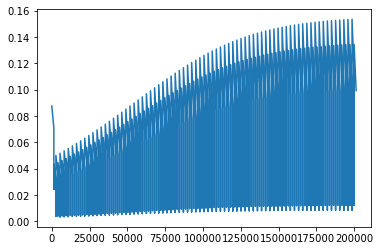

In [75]:
plt.plot(h_check_comm, h_check)

In [ ]:
df = pd.DataFrame(heatmap, index=ks, columns=trigger_betas)

In [ ]:
df

### GD

In [ ]:
max_iter = int(max_comm / (num_clients * len(x_0)) + 1)
h_GD, h_GD_comm = GD(x_0, X, y, lambda_, num_clients, max_iter)

## Plot

In [ ]:
len(h_CLAG_comm)

In [ ]:
plt.plot(h_EF21_comm, h_EF21, label='EF21', marker='+')
plt.plot(h_CLAG_comm, h_CLAG, label='CLAG', marker='D',
         markevery=30)
plt.plot(h_GD_comm, h_GD, label='GD', marker='*')
plt.plot(h_LAG_comm, h_LAG, label='LAG', marker='s',
         markevery=3)
plt.legend()
plt.xlabel('# of floats')
plt.ylabel(r'$||\nabla f(x^k)||^2$')
plt.title('phishing')
plt.xlim(left=0)
plt.grid()
plt.yscale('log')
plt.tight_layout()
plt.savefig('../results/phishing.pdf')

# a9a dataset

## Setup

In [ ]:
num_clients = 20

In [ ]:
lambda_ = 0.1

In [ ]:
dataset_name = 'a9a'

In [ ]:
raw_data = load_svmlight_file('../data/' + dataset_name)

In [ ]:
X, y = raw_data

In [ ]:
n = X.shape[0]

In [ ]:
d = X.shape[1]

In [ ]:
y

In [ ]:
inds = np.array_split(np.arange(n), num_clients)

In [ ]:
data = []
for i in range(num_clients):
    data.append((X[inds[i]][:], y[inds[i]]))

In [ ]:
L = smoothness(X, lambda_)

In [ ]:
L

In [ ]:
L_i = [smoothness(data[i][0], lambda_) for i in range(num_clients)]

In [ ]:
L_tilde = np.sqrt((np.array(L_i) ** 2).mean())

In [ ]:
L_tilde

## Experiments

In [ ]:
max_comm = 20000

### 1. LAG tuning

In [ ]:
zetas = np.geomspace(1e-2, 1e1, 4)

In [ ]:
x_0 = np.zeros(d, dtype=np.longdouble)

In [ ]:

LAG_histories = LAG_grid(x_0, data, lambda_, zetas, max_comm)

In [ ]:
with open('../results/lag_{}.pickle'.format(dataset_name), 'wb') as file:
    pickle.dump(LAG_histories, file)

In [ ]:
min_ind = print_and_return(LAG_histories)

In [ ]:
print(min_ind)

In [ ]:
h_LAG, h_LAG_comm = LAG_histories[min_ind]

In [ ]:
# preliminary plot
plt.plot(h_LAG_comm, h_LAG)
plt.yscale('log')

### 2. EF21 tuning

In [ ]:
ks = np.linspace(1, d, 10, endpoint=False, dtype=int)

In [ ]:
ks

In [ ]:
EF21_histories = EF21_grid(x_0, data, d, lambda_, ks, max_comm)

In [ ]:
with open('../results/ef21_{}.pickle'.format(dataset_name), 'wb') as file:
    pickle.dump(EF21_histories, file)

In [ ]:
min_ind = print_and_return(EF21_histories)

In [ ]:
min_ind

In [ ]:
h_EF21, h_EF21_comm = EF21_histories[min_ind]

In [ ]:
# preliminary plot
plt.plot(h_LAG_comm, h_LAG, label='LAG')
plt.plot(h_EF21_comm, h_EF21, label='EF21')
plt.legend()
plt.yscale('log')

### 3. CLAG tuning

In [ ]:
ks = np.linspace(1, d, 6, endpoint=True, dtype=int)

In [ ]:
ks = np.flip(ks)

In [ ]:
ks

In [ ]:
trigger_betas = [beta_top_k(k, d) for k in ks]

In [ ]:
trigger_betas = trigger_betas[:-1] + [10]

In [ ]:
beta_multipliers = np.geomspace(1e-1, 10, num=3)

In [ ]:
beta_multipliers

In [ ]:
ks

In [ ]:
CLAG_histories = CLAG_grid(x_0, data, lambda_, ks, beta_multipliers, max_comm)

In [ ]:
with open('../results/clag_{}.pickle'.format(dataset_name), 'wb') as file:
    pickle.dump(CLAG_histories, file)

In [ ]:
len(CLAG_histories)

In [ ]:
min_inds = []
for hist_k in CLAG_histories:
    ind = print_and_return(hist_k)
    min_inds.append(ind)

In [ ]:
min_inds

In [ ]:
min_list = [CLAG_histories[ind][min_inds[ind]] for ind in range(len(ks))]

In [ ]:
min_ind = print_and_return(min_list)

In [ ]:
min_ind

In [ ]:
h_CLAG, h_CLAG_comm = min_list[min_ind]

In [ ]:
# preliminary plot
plt.plot(h_LAG_comm, h_LAG, label='LAG')
plt.plot(h_EF21_comm, h_EF21, label='EF21')
plt.plot(h_CLAG_comm, h_CLAG, label='CLAG')
plt.legend()
plt.yscale('log')

In [ ]:
heatmap = heatmap_CLAG(x_0, data, lambda_, ks, trigger_betas, 1e-2, '../results/heatmap_a9a.npy')

In [ ]:
df = pd.DataFrame(heatmap, index=ks, columns=trigger_betas)

In [ ]:
df

### GD

In [ ]:
max_iter = int(max_comm / (num_clients * len(x_0)) + 1)
h_GD, h_GD_comm = GD(x_0, X, y, lambda_, num_clients, max_iter)

## Plot

In [ ]:
len(h_CLAG_comm)

In [ ]:
plt.plot(h_EF21_comm, h_EF21, label='EF21', marker='+')
plt.plot(h_CLAG_comm, h_CLAG, label='CLAG', marker='D',
         markevery=1500)
plt.plot(h_GD_comm, h_GD, label='GD', marker='*')
plt.plot(h_LAG_comm, h_LAG, label='LAG', marker='s',
         markevery=3)
plt.legend()
plt.xlabel('# of floats')
plt.ylabel(r'$||\nabla f(x^k)||^2$')
plt.title(dataset_name)
plt.xlim(left=0)
plt.grid()
plt.yscale('log')
plt.tight_layout()
plt.savefig('../results/{}.pdf'.format(dataset_name))

# w6a dataset

## Setup

In [ ]:
num_clients = 20

In [ ]:
lambda_ = 0.1

In [ ]:
dataset_name = 'w6a'

In [ ]:
raw_data = load_svmlight_file('../data/' + dataset_name)

In [ ]:
X, y = raw_data

In [ ]:
n = X.shape[0]

In [ ]:
d = X.shape[1]

In [ ]:
y

In [ ]:
inds = np.array_split(np.arange(n), num_clients)

In [ ]:
data = []
for i in range(num_clients):
    data.append((X[inds[i]][:], y[inds[i]]))

In [ ]:
L = smoothness(X, lambda_)

In [ ]:
L

In [ ]:
L_i = [smoothness(data[i][0], lambda_) for i in range(num_clients)]

In [ ]:
L_tilde = np.sqrt((np.array(L_i) ** 2).mean())

In [ ]:
L_tilde

## Experiments

In [ ]:
max_comm = 100000

### 1. LAG tuning

In [ ]:
zetas = np.geomspace(1e-2, 1e1, 4)

In [ ]:
x_0 = np.zeros(d)


In [ ]:
LAG_histories = LAG_grid(x_0, data, lambda_, zetas, max_comm)

In [ ]:
with open('../results/lag_{}.pickle'.format(dataset_name), 'wb') as file:
    pickle.dump(LAG_histories, file)

In [ ]:
min_ind = print_and_return(LAG_histories)

In [ ]:
print(min_ind)

In [ ]:
h_LAG, h_LAG_comm = LAG_histories[min_ind]

In [ ]:
# preliminary plot
plt.plot(h_LAG_comm, h_LAG)
plt.yscale('log')

### 2. EF21 tuning

In [ ]:
ks = np.linspace(1, d, 10, endpoint=False, dtype=int)

In [ ]:
ks

In [ ]:
EF21_histories = EF21_grid(x_0, data, d, lambda_, ks, max_comm)

In [ ]:
with open('../results/ef21_{}.pickle'.format(dataset_name), 'wb') as file:
    pickle.dump(EF21_histories, file)

In [ ]:
min_ind = print_and_return(EF21_histories)

In [ ]:
min_ind

In [ ]:
h_EF21, h_EF21_comm = EF21_histories[min_ind]

In [ ]:
# preliminary plot
plt.plot(h_LAG_comm, h_LAG, label='LAG')
plt.plot(h_EF21_comm, h_EF21, label='EF21')
plt.legend()
plt.yscale('log')

### 3. CLAG tuning

In [ ]:
ks = np.flip(np.linspace(1, d, 6, endpoint=True, dtype=int))

In [ ]:
ks = ks[:-1]

In [ ]:
ks

In [ ]:
trigger_betas = np.linspace(0, 50, 6, endpoint=True)

In [ ]:
trigger_betas

In [ ]:
beta_multipliers = np.geomspace(1e-1, 10, num=3)

In [ ]:
beta_multipliers

In [ ]:
ks

In [ ]:
CLAG_histories = CLAG_grid(x_0, data, lambda_, ks, beta_multipliers, max_comm)

In [ ]:
with open('../results/clag_{}.pickle'.format(dataset_name), 'wb') as file:
    pickle.dump(CLAG_histories, file)

In [ ]:
len(CLAG_histories)

In [ ]:
min_inds = []
for hist_k in CLAG_histories:
    ind = print_and_return(hist_k)
    min_inds.append(ind)

In [ ]:
min_inds

In [ ]:
min_list = [CLAG_histories[ind][min_inds[ind]] for ind in range(len(ks))]

In [ ]:
min_ind = print_and_return(min_list)

In [ ]:
min_ind

In [ ]:
h_CLAG, h_CLAG_comm = min_list[min_ind]

In [ ]:
# preliminary plot
plt.plot(h_LAG_comm, h_LAG, label='LAG')
plt.plot(h_EF21_comm, h_EF21, label='EF21')
plt.plot(h_CLAG_comm, h_CLAG, label='CLAG')
plt.legend()
plt.yscale('log')

In [ ]:
heatmap = heatmap_CLAG(x_0, data, lambda_, ks, trigger_betas, 1e-2, '../results/heatmap_w6a.npy')

In [ ]:
df = pd.DataFrame(heatmap, index=ks, columns=trigger_betas)

In [ ]:
df

### GD

In [ ]:
max_iter = int(max_comm / (num_clients * len(x_0)) + 1)
h_GD, h_GD_comm = GD(x_0, data, lambda_, num_clients, max_iter)

## Plot

In [ ]:
len(h_CLAG_comm)

In [ ]:
plt.plot(h_EF21_comm, h_EF21, label='EF21', marker='+')
plt.plot(h_CLAG_comm, h_CLAG, label='CLAG', marker='D',
         markevery=700)
plt.plot(h_GD_comm, h_GD, label='GD', marker='*')
plt.plot(h_LAG_comm, h_LAG, label='LAG', marker='s',
         markevery=10)
plt.legend()
plt.xlabel('# of floats')
plt.ylabel(r'$||\nabla f(x^k)||^2$')
plt.title(dataset_name)
plt.xlim(left=0)
plt.grid()
plt.yscale('log')
plt.tight_layout()
plt.savefig('../results/{}.pdf'.format(dataset_name))

In [ ]:
h_check, h_check_comm = CLAG(x_0, data, lambda_, 30, 10, 100000)

In [ ]:
plt.plot(h_check_comm, h_check)
plt.yscale('log')